## Uber Ride Fare Prediction using Machine Learning Algorithms

####

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as py
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### Reading the dataset

In [2]:
df = pd.read_csv('uber.csv')

### Data cleaning

#### Dropping two columns that aren't relevant for our study

In [3]:
df = df.drop(columns = ['Unnamed: 0', 'key'])

#### Checking the presence of null and duplicated data and removing it

In [4]:
print(df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [5]:
print(df[df.isnull().any(axis=1)])

       fare_amount          pickup_datetime  pickup_longitude  \
87946         24.1  2013-07-02 03:51:57 UTC        -73.950581   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
87946        40.779692                NaN               NaN                0  


In [6]:
df = df.dropna()

In [7]:
df.duplicated().sum()

0

#### Checking the type of each column in the dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


#### Analysing the "passenger_count" column

In [9]:
df['passenger_count'].value_counts()

1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         708
208         1
Name: passenger_count, dtype: int64

#### We can notice that there is an unrealistic case where there is a ride with 208 passengers, which we will remove from the analysis.
#### Additionally, there are 708 rides with 0 passengers. Uber's delivery service didn't exist on the years of the data present. Therefore, I have chosen to exclude rides without passengers from the dataframe.

In [10]:
df = df[(df['passenger_count'] != 208) & (df['passenger_count'] != 0)]
df['passenger_count'].value_counts()

1    138425
2     29428
5     14009
3      8881
4      4276
6      4271
Name: passenger_count, dtype: int64

#### Analysing "fare_amount"

In [11]:
df['fare_amount'].describe()

count    199290.000000
mean         11.366713
std           9.910588
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [12]:
df1 = df['fare_amount'].value_counts()
df1.loc[df1.index < 6]

 4.50     8209
 5.70     5825
 5.30     5803
 4.90     5540
 4.10     4188
 5.50     3987
 5.00     3768
 3.70     2849
 4.00     2072
 3.30     1379
 3.50     1088
 2.50      820
 2.90      473
 3.00      355
 5.40       62
 5.80       59
 4.60       51
 5.90       49
 4.20       41
 5.10       25
 3.80       24
 4.70       19
 4.30       13
 3.40       10
 0.00        5
 3.90        4
-3.50        3
-3.00        2
-52.00       2
 0.01        2
 3.25        1
-5.70        1
-6.90        1
-5.50        1
-10.90       1
 0.11        1
-50.50       1
-5.00        1
-3.30        1
 2.60        1
-23.70       1
-7.30        1
-49.57       1
Name: fare_amount, dtype: int64

In [13]:
df1.loc[df1.index < 0.2].sum()

25

In [14]:
df = df[df['fare_amount'] > 0.2]

#### We can see that some uber rides have negative values and others are below 0.20. We have chosen to remove these 25 cases from the analysis.

In [15]:
df['fare_amount'].describe()

count    199265.000000
mean         11.369588
std           9.905854
min           2.500000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

#### Apparent inconsistent values of rides fares still exists, but we will analyse further along with the information of distance. 

####

#### Creating the variable distance

#### We will use the Haversine formula, which is an equation used in navigation, providing the distance between 2 points on a sphere based on their latitudes and longitudes, to calculate the distance between the start and end of the ride.

####

#### Defining criteria for latitudes and longitudes to remove rows that don't make sense.

In [16]:
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180

df = df[(df['pickup_latitude'] >= lat_min) & (df['pickup_latitude'] <= lat_max) &
        (df['dropoff_latitude'] >= lat_min) & (df['dropoff_latitude'] <= lat_max) &
        (df['pickup_longitude'] >= lon_min) & (df['pickup_longitude'] <= lon_max) &
        (df['dropoff_longitude'] >= lon_min) & (df['dropoff_longitude'] <= lon_max)]


In [17]:
def haversine_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371.0

    # Converting degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Difference between latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine Formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = earth_radius * c

    return distance


In [18]:
for index, row in df.iterrows():
    distance = haversine_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])

    df.at[index, 'distance'] = distance

In [19]:
df['distance'].describe()

count    199253.000000
mean         20.321105
std         376.850835
min           0.000000
25%           1.215430
50%           2.121999
75%           3.875852
max        8782.898606
Name: distance, dtype: float64

In [20]:
df2 = df['distance'].value_counts()
df2.loc[df2.index < 0.1]

0.000000    5612
0.000424       5
0.000334       2
0.000778       2
0.000556       2
            ... 
0.007623       1
0.008364       1
0.073476       1
0.038668       1
0.001101       1
Name: distance, Length: 1155, dtype: int64

In [21]:
df2.loc[df2.index < 0.1].sum()

6774

#### 5612 rides with zero distance were identified and will be excluded from the analysis. Furthermore, for the sake of reasonableness, 1162 rides with distances less than 100m (0.1) will also be disregarded.

In [22]:
df = df[df['distance'] > 0.1]

In [23]:
df['distance'].describe()

count    192479.000000
mean         21.036099
std         383.405260
min           0.100227
25%           1.296620
50%           2.197383
75%           3.980016
max        8782.898606
Name: distance, dtype: float64

In [ ]:
py.scatter(df, x = df['distance'], y = df['fare_amount'])

#Output Removed to reduce notebook size

#### After a graphical analysis, we observed many rides with completely unrealistic distances. Additionally, we noticed some cases where the distance-price relationship doesn't make sense. Therefore, at this initial stage, we chose to remove all variables with distances greater than 170 km.

In [25]:
df = df[df['distance'] < 170]

In [ ]:
py.scatter(df, x = df['distance'], y = df['fare_amount'])

#Output Removed to reduce notebook size

#### Upon reevaluation within this revised range, it appears that rides covering distances up to 60 km maintain a realistic relationship between distance and price. As a result, we will further refine our selection, considering only rides with distances up to 60 km.

In [27]:
df = df[df['distance'] < 60]

In [ ]:
py.scatter(df, x = df['distance'], y = df['fare_amount'])

#Output eemoved to reduce notebook size

#### Removing the ride with fare of $220 with a distance of 2.9 km.

In [29]:
df = df[df['fare_amount'] != 220]

### Uber races location

#### After a preliminary analysis, we found that the majority of rides took place in the territory of the United States. What we'll do is verify if this indeed occurred. The idea is to consider only these rides.

####

#### In this code, we'll roughly define a polygon that encompasses the geographical boundaries of the USA. Anything not captured within this polygon will be classified as 'Unknown'.

In [30]:
us_polygon = Polygon([
    (-125, 24),  # Lower left boundary
    (-66, 24),   # Lower right boundary
    (-66, 49),   # Upper right boundary
    (-125, 49),  # Upper left boundary
])

def country_pickup(row):
    point = Point(row['pickup_longitude'], row['pickup_latitude'])
    if us_polygon.contains(point):
        return 'United States'
    else:
        return 'Unknown'

def country_dropoff(row):
    if row['country'] == 'Unknown':
        point = Point(row['dropoff_longitude'], row['dropoff_latitude'])
        if us_polygon.contains(point):
            return 'United States'
        else:
            return 'Unknown'
    else:
        return row['country']


df['country'] = df.apply(country_pickup, axis=1)
df['country'] = df.apply(country_dropoff, axis=1)

In [31]:
df['country'].value_counts()

United States    191887
Unknown             114
Name: country, dtype: int64

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get the country information
def get_country_pickup(row):
    if row['country'] == 'Unknown':
        try:
            location = geolocator.reverse((row['pickup_latitude'], row['pickup_longitude']), exactly_one=True)
            address = location.raw.get('address', {})
            country = address.get('country', 'Unknown')
            return country
        except:
            return 'Unknown'
    else:
        return row['country']

# Counting variable
count_unknown_rows = 0

# Applying the function to obtain the country and monitoring the 'Unknown' lines.
for index, row in df.iterrows():
    if row['country'] == 'Unknown':
        count_unknown_rows += 1
        print("Number of 'Unknown' lines processed:", count_unknown_rows)
    df.at[index, 'country'] = get_country_pickup(row)


In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

def get_country_dropoff(row):
    if row['country'] == 'Unknown':
        try:
            location = geolocator.reverse((row['dropoff_latitude'], row['dropoff_longitude']), exactly_one=True)
            address = location.raw.get('address', {})
            country = address.get('country', 'Unknown')
            return country
        except:
            return 'Unknown'
    else:
        return row['country']

count_unknown_rows = 0

for index, row in df.iterrows():
    if row['country'] == 'Unknown':
        count_unknown_rows += 1
        print("Number of 'Unknown' lines processed: ", count_unknown_rows)
    df.at[index, 'country'] = get_country_dropoff(row)


In [34]:
df['country'].unique()

array(['United States', 'Unknown'], dtype=object)

In [35]:
print("Unknown : " ,(df['country'] == 'Unknown').sum())
print("United States : " ,(df['country'] == 'United States').sum())

Unknown :  114
United States :  191887


In [36]:
# Removing every observation outside of United States
df = df[df['country'] == "United States"]

### Deconstructing the 'pickup_datetime' variable to get more information.

#### The intention is to leverage this information-rich variable for the creation of other potential explanatory variables.

####

#### First of all, creating the variables date, year, month, hour, and day of the week.

In [37]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['date'] = df['pickup_datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

month_name = {
    1 : 'january',
    2 : 'february',
    3 : 'march',
    4 : 'april',
    5 : 'may',
    6 : 'june',
    7 : 'july',
    8 : 'august',
    9 : 'september',
    10 : 'october',
    11 : 'november',
    12 : 'december'
}

df['month'] = df['month'].map(month_name)

df['time'] = df['pickup_datetime'].dt.time
df['hour'] = df['time'].apply(lambda x: x.hour)

df['day_of_week'] = df['pickup_datetime'].dt.day_name()


In [38]:
# one-hot encoding the day_of_week column
one_hot_encoded = pd.get_dummies(df['day_of_week'], prefix= 'day')

df = pd.concat([df, one_hot_encoded], axis=1)


#### Creating a variable that indicates whether it is morning, afternoon, evening, or late night.

In [39]:
def time_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'night'
    else:
        return 'late night'


df['time_period'] = df['hour'].apply(time_period)

In [40]:
# one-hot encoding the time_period column
one_hot_encoded = pd.get_dummies(df['time_period'], prefix= 'period')

df = pd.concat([df, one_hot_encoded], axis=1)

#### Using the 'holidays' package to determine if it is a holiday in the USA.

In [41]:
import holidays

def is_holiday_us(row):
    us_holidays = holidays.US(years=row['year'])
    return row['date'] in us_holidays

df['holiday'] = df.apply(is_holiday_us, axis=1)

In [42]:
df['holiday'].value_counts()

False    187559
True       4328
Name: holiday, dtype: int64

In [43]:
# one-hot encoding the "holiday" column
holiday_one_hot_encoded = pd.get_dummies(df['holiday'], prefix = 'holiday')

df = pd.concat([df, holiday_one_hot_encoded], axis=1)

#### Creating the variable that represents the season

In [44]:
def season_of_year(row):
    date = row['date']
    country = row['country']

    if (date.month >= 3 and date.month <= 5):
        return 'spring'
    elif (date.month >= 6 and date.month <= 8):
        return 'summer'
    elif (date.month >= 9 and date.month <= 11):
        return 'fall'
    else:
        return 'winter'


df['season'] = df.apply(season_of_year, axis=1)

In [45]:
# one-hot encoding the "season" column
season_one_hot_encoded = pd.get_dummies(df['season'], prefix= 'season')

df = pd.concat([df, season_one_hot_encoded], axis=1)

#### Creating a variable that indicates if it's rush hour

In [46]:
def is_rush_hour(row):
    time = row['time']
    country = row['country']

    if (7 <= time.hour < 10) or (16 <= time.hour < 19):
        return True
    else:
        return False


df['rush_hour'] = df.apply(is_rush_hour, axis=1)

In [47]:
# one-hot encoding a coluna 'rush_hour'
rush_one_hot_encoded = pd.get_dummies(df['rush_hour'], prefix= 'rush_hour')

df = pd.concat([df, rush_one_hot_encoded], axis=1)

## Exploratory Data Analysis

### Correlation

In [48]:
feat_quant = ['passenger_count','year','pickup_longitude','pickup_latitude','dropoff_longitude',
              'dropoff_latitude','distance']
feat_quali = ['day_of_week', 'holiday', 'season', 'rush_hour']

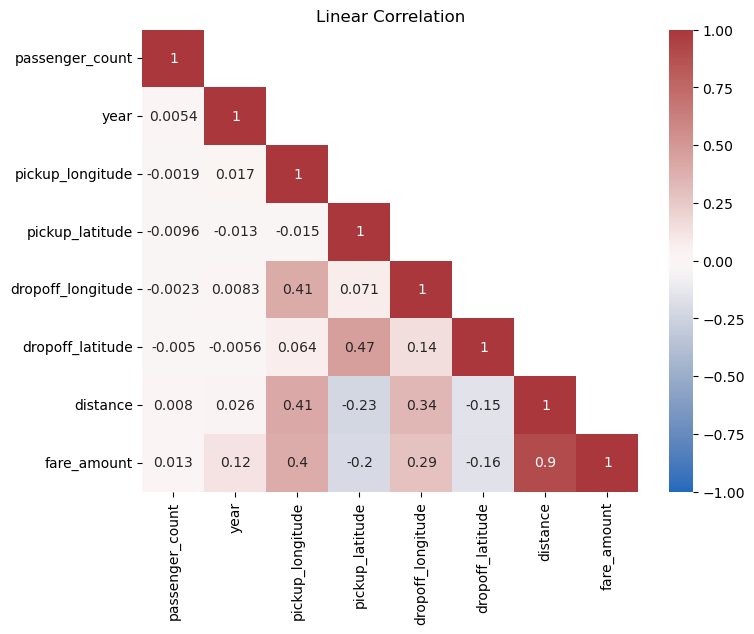

In [49]:
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(df[[*feat_quant, 'fare_amount']].corr(), dtype=bool))
np.fill_diagonal(mask, False)
sns.heatmap(df[[*feat_quant, 'fare_amount']].corr(method = 'pearson'), annot=True, mask=mask, vmin=-1, vmax=1, cmap = "vlag")
plt.title('Linear Correlation')
plt.show()

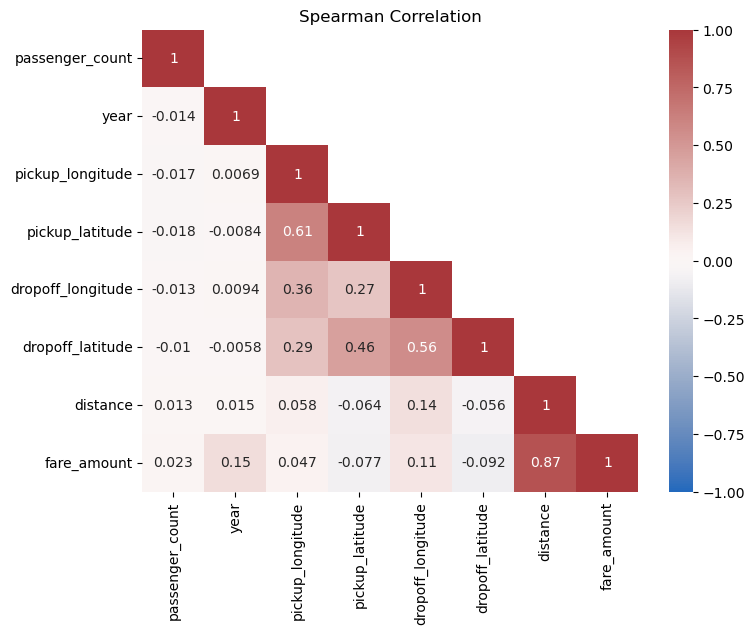

In [50]:
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(df[[*feat_quant, 'fare_amount']].corr(), dtype=bool))
np.fill_diagonal(mask, False)
sns.heatmap(df[[*feat_quant, 'fare_amount']].corr(method = 'spearman'), annot=True, mask=mask, vmin=-1, vmax=1, cmap = "vlag")
plt.title('Spearman Correlation')
plt.show()

## Number of passengers

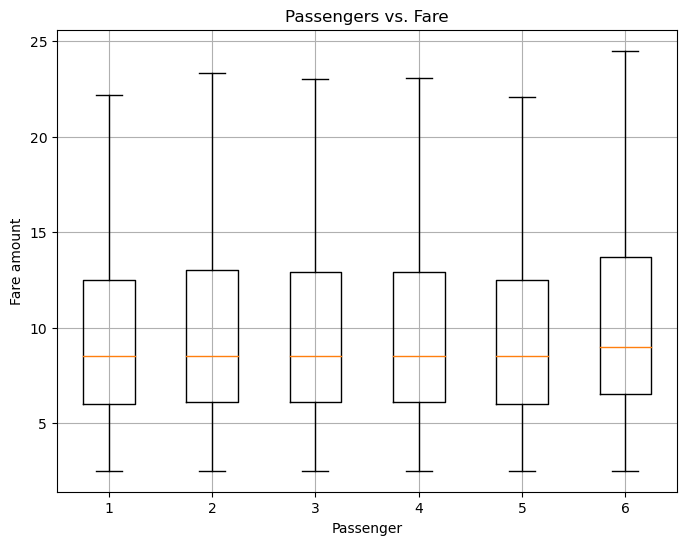

In [51]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['passenger_count'] == 1]['fare_amount'],
             df[df['passenger_count'] == 2]['fare_amount'],
             df[df['passenger_count'] == 3]['fare_amount'],
             df[df['passenger_count'] == 4]['fare_amount'],
             df[df['passenger_count'] == 5]['fare_amount'],
             df[df['passenger_count'] == 6]['fare_amount']],
             labels=[1, 2, 3, 4, 5, 6], showfliers=False)

plt.xlabel('Passenger')
plt.ylabel('Fare amount')
plt.title('Passengers vs. Fare')
plt.grid(True)
plt.show()

#### As expected after analyzing the correlation plot, it seems that the number of passengers does not influence the ride fare.

####

## Holiday

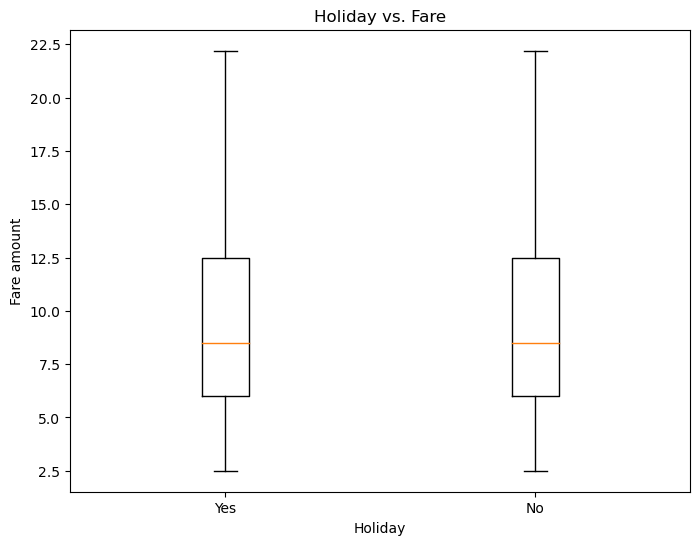

In [52]:
plt.figure(figsize=(8, 6))

holiday_data = df[df['holiday'] == True]['fare_amount']
not_holiday_data = df[df['holiday'] == False]['fare_amount']

plt.boxplot([holiday_data, not_holiday_data], labels=['Yes', 'No'], showfliers=False)

plt.xlabel('Holiday')
plt.ylabel('Fare amount')
plt.title('Holiday vs. Fare')

plt.show()

#### Apparently, being a holiday or not does not influence the ride fare.

####

## Day of week

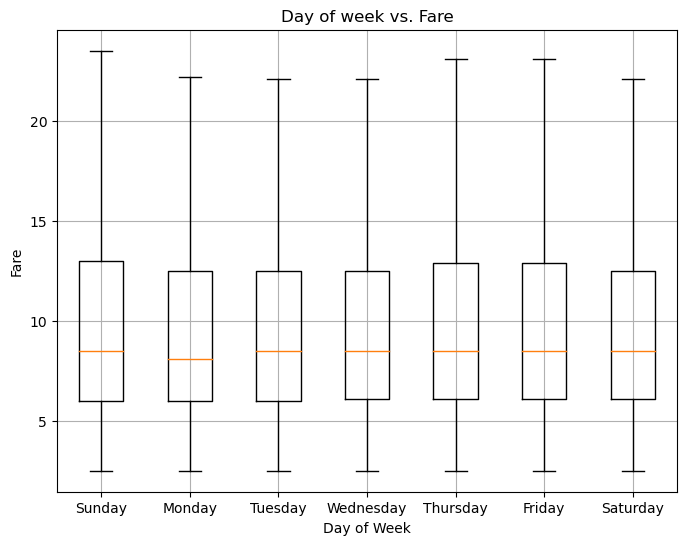

In [53]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['day_of_week'] == 'Sunday']['fare_amount'],
             df[df['day_of_week'] == "Monday"]['fare_amount'],
             df[df['day_of_week'] == "Tuesday"]['fare_amount'],
             df[df['day_of_week'] == "Wednesday"]['fare_amount'],
             df[df['day_of_week'] == "Thursday"]['fare_amount'],
             df[df['day_of_week'] == "Friday"]['fare_amount'],
             df[df['day_of_week'] == "Saturday"]['fare_amount']],
             labels=["Sunday", 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                     "Friday", 'Saturday'], showfliers=False)

plt.xlabel('Day of Week')
plt.ylabel('Fare')
plt.title('Day of week vs. Fare')
plt.grid(True)
plt.show()

#### The day the ride is taken does not have a significant influence on the ride fare.

####

## Year

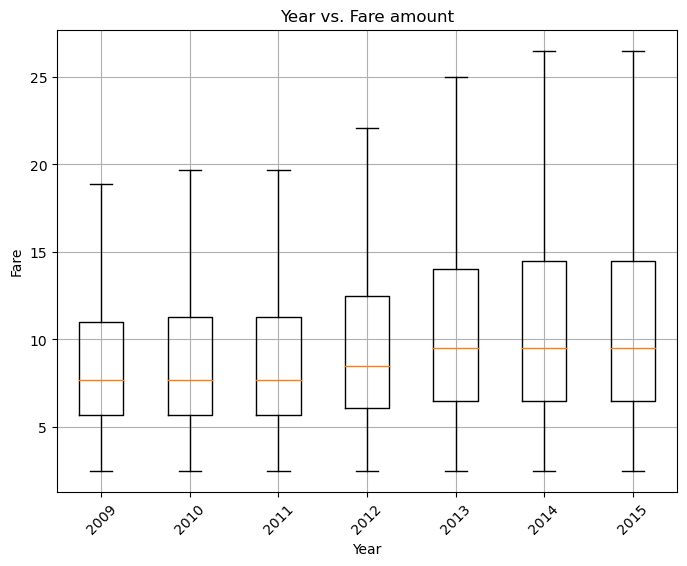

In [54]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['year'] == 2009]['fare_amount'],
             df[df['year'] == 2010]['fare_amount'],
             df[df['year'] == 2011]['fare_amount'],
             df[df['year'] == 2012]['fare_amount'],
             df[df['year'] == 2013]['fare_amount'],
             df[df['year'] == 2014]['fare_amount'],
             df[df['year'] == 2015]['fare_amount']],
            labels=[2009, 2010, 2011, 2012, 2013, 2014, 2015], showfliers=False)

plt.xlabel('Year')
plt.ylabel('Fare')
plt.title('Year vs. Fare amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### We observed a slight increase in ride fares over the years, which could be explained by inflation over time.

####

## Month

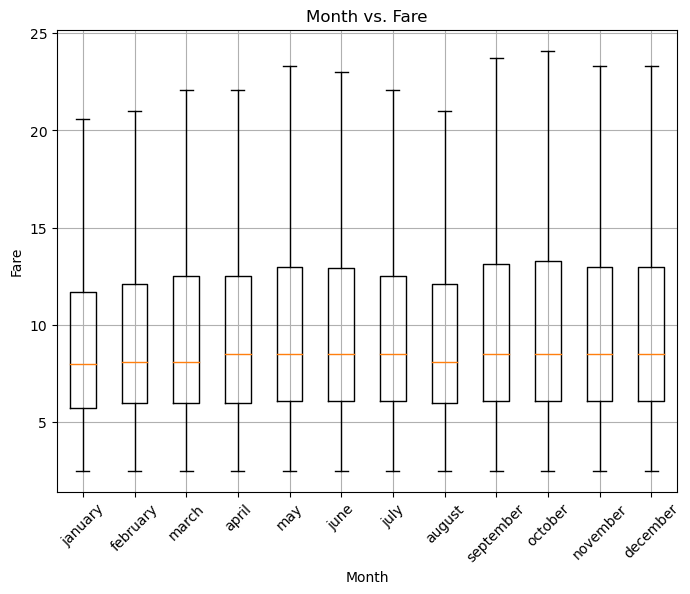

In [55]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['month'] == 'january']['fare_amount'],
             df[df['month'] == 'february']['fare_amount'],
             df[df['month'] == 'march']['fare_amount'],
             df[df['month'] == 'april']['fare_amount'],
             df[df['month'] == 'may']['fare_amount'],
             df[df['month'] == 'june']['fare_amount'],
             df[df['month'] == 'july']['fare_amount'],
             df[df['month'] == 'august']['fare_amount'],
             df[df['month'] == 'september']['fare_amount'],
             df[df['month'] == 'october']['fare_amount'],
             df[df['month'] == 'november']['fare_amount'],
             df[df['month'] == 'december']['fare_amount']],
            labels=['january', 'february', 'march', 'april', 'may', 'june',
                    'july', 'august', 'september', 'october', 'november', 'december'], showfliers=False)

plt.xlabel('Month')
plt.ylabel('Fare')
plt.title('Month vs. Fare')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Once more, there is no discernible impact of the 'month' variable on the ride fares.

####

## Hour

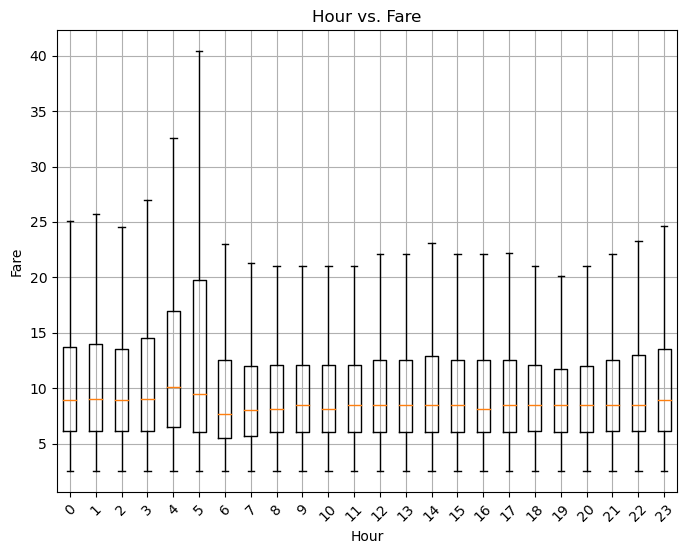

In [56]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['hour'] == 0]['fare_amount'],
             df[df['hour'] == 1]['fare_amount'],
             df[df['hour'] == 2]['fare_amount'],
             df[df['hour'] == 3]['fare_amount'],
             df[df['hour'] == 4]['fare_amount'],
             df[df['hour'] == 5]['fare_amount'],
             df[df['hour'] == 6]['fare_amount'],
             df[df['hour'] == 7]['fare_amount'],
             df[df['hour'] == 8]['fare_amount'],
             df[df['hour'] == 9]['fare_amount'],
             df[df['hour'] == 10]['fare_amount'],
             df[df['hour'] == 11]['fare_amount'],
             df[df['hour'] == 12]['fare_amount'],
             df[df['hour'] == 13]['fare_amount'],
             df[df['hour'] == 14]['fare_amount'],
             df[df['hour'] == 15]['fare_amount'],
             df[df['hour'] == 16]['fare_amount'],
             df[df['hour'] == 17]['fare_amount'],
             df[df['hour'] == 18]['fare_amount'],
             df[df['hour'] == 19]['fare_amount'],
             df[df['hour'] == 20]['fare_amount'],
             df[df['hour'] == 21]['fare_amount'],
             df[df['hour'] == 22]['fare_amount'],
             df[df['hour'] == 23]['fare_amount']],
            labels=[0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], showfliers=False)

plt.xlabel('Hour')
plt.ylabel('Fare')
plt.title('Hour vs. Fare')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### We observed that the time between 4 and 5 AM stands out, seemingly having slightly higher prices compared to others.

####

## Rush Hour

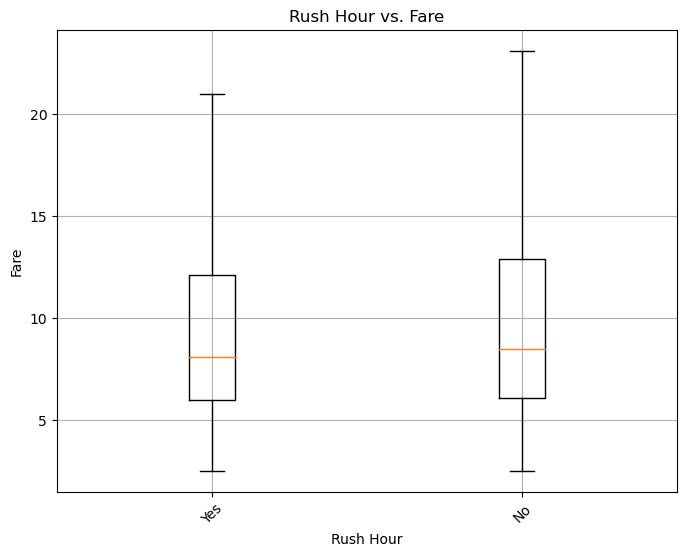

In [57]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['rush_hour'] == True]['fare_amount'],
             df[df['rush_hour'] == False]['fare_amount']],
            labels=["Yes", "No"], showfliers = False)

plt.xlabel('Rush Hour')
plt.ylabel('Fare')
plt.title('Rush Hour vs. Fare')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Rush hour did not prove to be a good variable to explain price variation.

####

## Time Period

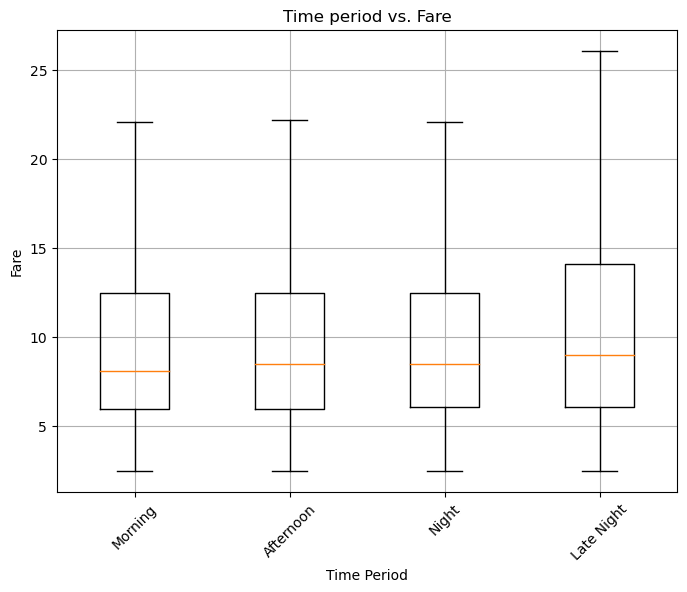

In [58]:
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['time_period'] == "morning"]['fare_amount'],
             df[df['time_period'] == "afternoon"]['fare_amount'],
             df[df['time_period'] == "night"]['fare_amount'],
             df[df['time_period'] == "late night"]['fare_amount']],
            labels=["Morning", "Afternoon", "Night", "Late Night"], showfliers=False)

plt.xlabel('Time Period')
plt.ylabel('Fare')
plt.title('Time period vs. Fare')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Supporting what was observed in the 'hour' variable, we can notice a slight difference in the early morning shift compared to others.

####

## Season

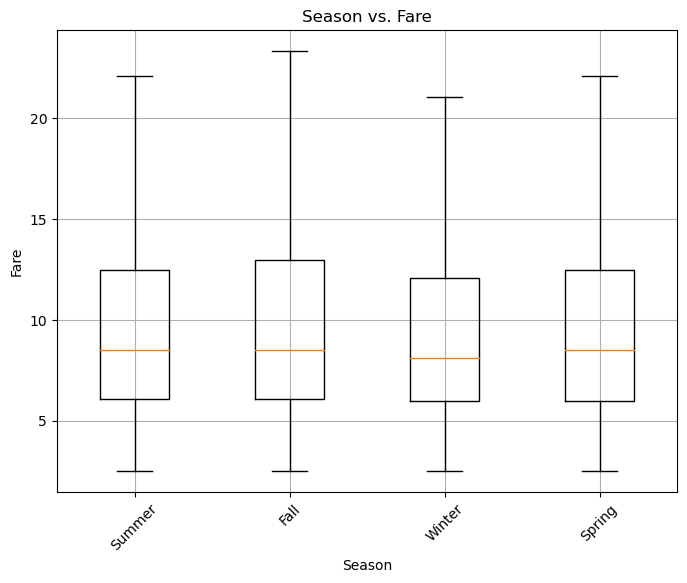

In [59]:
df['season']
plt.figure(figsize=(8, 6))

plt.boxplot([df[df['season'] == "summer"]['fare_amount'],
             df[df['season'] == "fall"]['fare_amount'],
             df[df['season'] == "winter"]['fare_amount'],
             df[df['season'] == "spring"]['fare_amount']],
            labels=["Summer", "Fall", "Winter", "Spring"], showfliers=False)

plt.xlabel('Season')
plt.ylabel('Fare')
plt.title('Season vs. Fare')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Apparently, the season of the year does not influence the ride fare.

####

## Models

In [60]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

#### To facilitate model construction, we will split the dataset in half.

In [61]:
#data_size = len(df) // 2

#df = df.sample(n = data_size, random_state=42)

In [62]:
x = df[['distance','year','passenger_count','day_Friday', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday','period_late night',
       'period_morning', 'period_night', 'period_afternoon', 'holiday_False',
       'holiday_True', 'season_winter', 'season_fall',
       'season_spring', 'season_summer']]
y = df['fare_amount']

In [63]:
LR = LinearRegression()
Rid = Ridge()
Las = Lasso()
ElaNet = ElasticNet()
KNN = KNeighborsRegressor()
RFR = RandomForestRegressor(n_estimators = 1000, max_depth = None,
                            min_samples_leaf = 5, max_features = 'sqrt')

In [64]:
param_grid_Las = {"alpha": [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

param_grid_Rid = {"alpha": [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

param_grid_ElaNet = {"alpha": [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
                     "l1_ratio": [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}
param_grid_KNN = {"n_neighbors": range(1,50)}

In [65]:
LasCV = GridSearchCV(Las, param_grid = param_grid_Las, scoring='neg_mean_squared_error', cv = 5, n_jobs=-1)
RidCV = GridSearchCV(Rid, param_grid = param_grid_Rid, scoring='neg_mean_squared_error', cv = 5, n_jobs=-1)
ElaNetCV = GridSearchCV(ElaNet, param_grid = param_grid_ElaNet, scoring='neg_mean_squared_error', cv = 5, n_jobs=-1)
KNNCV = GridSearchCV(KNN, param_grid = param_grid_KNN, scoring='neg_mean_squared_error', cv = 5, n_jobs=-1)

### Model with distance

In [66]:
x_dist = df['distance']
y_dist = df['fare_amount']

In [67]:
x_dist_tr, x_dist_tt, y_dist_tr, y_dist_tt = train_test_split(x_dist, y_dist, test_size = 0.3)

In [68]:
x_dist_tr_array = x_dist_tr.to_numpy()

x_dist_tr_reshaped = x_dist_tr_array.reshape(-1, 1)

x_dist_tt_array = x_dist_tt.to_numpy()

x_dist_tt_reshaped = x_dist_tt_array.reshape(-1, 1)

In [69]:
LR.fit(x_dist_tr_reshaped , y_dist_tr)
LasCV.fit(x_dist_tr_reshaped , y_dist_tr)
RidCV.fit(x_dist_tr_reshaped , y_dist_tr)
ElaNetCV.fit(x_dist_tr_reshaped , y_dist_tr)
KNNCV.fit(x_dist_tr_reshaped , y_dist_tr)
RFR.fit(x_dist_tr_reshaped , y_dist_tr)

print(LasCV.best_estimator_)
print(RidCV.best_estimator_)
print(ElaNetCV.best_estimator_)
print(KNNCV.best_estimator_)

Lasso(alpha=0.001)
Ridge(alpha=0.001)
ElasticNet(alpha=0.001, l1_ratio=1)
KNeighborsRegressor(n_neighbors=45)


In [70]:
y_dist_tt_predict_LR = LR.predict(x_dist_tt_reshaped)
y_dist_tt_predict_Las = LasCV.predict(x_dist_tt_reshaped)
y_dist_tt_predict_Rid = RidCV.predict(x_dist_tt_reshaped)
y_dist_tt_predict_ElaNet = ElaNetCV.predict(x_dist_tt_reshaped)
y_dist_tt_predict_KNN = KNNCV.predict(x_dist_tt_reshaped)
y_dist_tt_predict_RFR = RFR.predict(x_dist_tt_reshaped)

In [71]:
# MSE
print("MSE Linear Regression: ", MSE(y_dist_tt_predict_LR, y_dist_tt))
print("MSE Lasso: ", MSE(y_dist_tt_predict_Las, y_dist_tt))
print("MSE Ridge: ", MSE(y_dist_tt_predict_Rid, y_dist_tt))
print("MSE Elastic Net: ", MSE(y_dist_tt_predict_ElaNet, y_dist_tt))
print("MSE KNN: ", MSE(y_dist_tt_predict_KNN, y_dist_tt))
print("MSE Random Forest: ", MSE(y_dist_tt_predict_RFR, y_dist_tt), "\n")

# MAE
print("MAE Linear Regression: ", MAE(y_dist_tt_predict_LR, y_dist_tt))
print("MAE Lasso: ", MAE(y_dist_tt_predict_Las, y_dist_tt))
print("MAE Ridge: ", MAE(y_dist_tt_predict_Rid, y_dist_tt))
print("MAE Elastic Net: ", MAE(y_dist_tt_predict_ElaNet, y_dist_tt))
print("MAE KNN: ", MAE(y_dist_tt_predict_KNN, y_dist_tt))
print("MAE Random Forest: ", MAE(y_dist_tt_predict_RFR, y_dist_tt), "\n")

#R²
print("R² Linear Regression: ", r2(y_dist_tt_predict_LR, y_dist_tt))
print("R² Lasso: ", r2(y_dist_tt_predict_Las, y_dist_tt))
print("R² Ridge: ", r2(y_dist_tt_predict_Rid, y_dist_tt))
print("R² Elastic Net: ", r2(y_dist_tt_predict_ElaNet, y_dist_tt))
print("R² KNN: ", r2(y_dist_tt_predict_KNN, y_dist_tt))
print("R² Random Forest: ", r2(y_dist_tt_predict_RFR, y_dist_tt), "\n")

MSE Linear Regression:  16.514405841273373
MSE Lasso:  16.51439837659186
MSE Ridge:  16.514405841140444
MSE Elastic Net:  16.51439837659186
MSE KNN:  16.499416318220725
MSE Random Forest:  17.66577533177446 

MAE Linear Regression:  2.2415217071628586
MAE Lasso:  2.241530284337084
MAE Ridge:  2.2415217073133444
MAE Elastic Net:  2.241530284337084
MAE KNN:  2.257445264744655
MAE Random Forest:  2.4009594659282176 

R² Linear Regression:  0.7726904347907109
R² Lasso:  0.7726757322627349
R² Ridge:  0.7726904345315961
R² Elastic Net:  0.7726757322627349
R² KNN:  0.7713614589607716
R² Random Forest:  0.7643824339472831 



####

### Modeling with distance, year and hour

In [72]:
df['new_hour'] = df['hour'].apply(lambda x: x if x in [4, 5] else 'other hours')

In [73]:
hour_one_hot_encoded = pd.get_dummies(df['new_hour'], prefix= 'hour')

df = pd.concat([df, hour_one_hot_encoded], axis=1)

In [74]:
x_changed = df[['distance','year','hour_4', 'hour_5', 'hour_other hours']]
y_changed = df['fare_amount']

In [75]:
x_changed_tr, x_changed_tt, y_changed_tr, y_changed_tt = train_test_split(x_changed, y_changed, test_size = 0.3)

In [76]:
LR.fit(x_changed_tr , y_changed_tr)
LasCV.fit(x_changed_tr , y_changed_tr)
RidCV.fit(x_changed_tr , y_changed_tr)
ElaNetCV.fit(x_changed_tr , y_changed_tr)
KNNCV.fit(x_changed_tr , y_changed_tr)
RFR.fit(x_changed_tr , y_changed_tr)

print(LasCV.best_estimator_)
print(RidCV.best_estimator_)
print(ElaNetCV.best_estimator_)
print(KNNCV.best_estimator_)

Lasso(alpha=0.001)
Ridge(alpha=100)
ElasticNet(alpha=0.001, l1_ratio=0.1)
KNeighborsRegressor(n_neighbors=48)


In [77]:
y_changed_tt_predict_LR = LR.predict(x_changed_tt)
y_changed_tt_predict_Las = LasCV.predict(x_changed_tt)
y_changed_tt_predict_Rid = RidCV.predict(x_changed_tt)
y_changed_tt_predict_ElaNet = ElaNetCV.predict(x_changed_tt)
y_changed_tt_predict_KNN = KNNCV.predict(x_changed_tt)
y_changed_tt_predict_RFR = RFR.predict(x_changed_tt)

In [78]:
# MSE
print("MSE Linear Regression: ", MSE(y_changed_tt_predict_LR, y_changed_tt))
print("MSE Lasso: ", MSE(y_changed_tt_predict_Las, y_changed_tt))
print("MSE Ridge: ", MSE(y_changed_tt_predict_Rid, y_changed_tt))
print("MSE Elastic Net: ", MSE(y_changed_tt_predict_ElaNet, y_changed_tt))
print("MSE KNN: ", MSE(y_changed_tt_predict_KNN, y_changed_tt))
print("MSE Random Forest: ", MSE(y_changed_tt_predict_RFR, y_changed_tt), "\n")

# MAE
print("MAE Linear Regression: ", MAE(y_changed_tt_predict_LR, y_changed_tt))
print("MAE Lasso: ", MAE(y_changed_tt_predict_Las, y_changed_tt))
print("MAE Ridge: ", MAE(y_changed_tt_predict_Rid, y_changed_tt))
print("MAE Elastic Net: ", MAE(y_changed_tt_predict_ElaNet, y_changed_tt))
print("MAE KNN: ", MAE(y_changed_tt_predict_KNN, y_changed_tt))
print("MAE Random Forest: ", MAE(y_changed_tt_predict_RFR, y_changed_tt), "\n")

#R²
print("R² Linear Regression: ", r2(y_changed_tt_predict_LR, y_changed_tt))
print("R² Lasso: ", r2(y_changed_tt_predict_Las, y_changed_tt))
print("R² Ridge: ", r2(y_changed_tt_predict_Rid, y_changed_tt))
print("R² Elastic Net: ", r2(y_changed_tt_predict_ElaNet, y_changed_tt))
print("R² KNN: ", r2(y_changed_tt_predict_KNN, y_changed_tt))
print("R² Random Forest: ", r2(y_changed_tt_predict_RFR, y_changed_tt), "\n")

MSE Linear Regression:  16.946653093007498
MSE Lasso:  16.946485021892162
MSE Ridge:  16.946620628397504
MSE Elastic Net:  16.946623859038397
MSE KNN:  15.927904613758932
MSE Random Forest:  16.986909567529757 

MAE Linear Regression:  2.2009721837471594
MAE Lasso:  2.200842039364812
MAE Ridge:  2.200925302698853
MAE Elastic Net:  2.2009115981976777
MAE KNN:  2.098704683238661
MAE Random Forest:  2.230424635050737 

R² Linear Regression:  0.7732378865644709
R² Lasso:  0.773216241710013
R² Ridge:  0.7732091471090448
R² Elastic Net:  0.7732010420751818
R² KNN:  0.7881336153462144
R² Random Forest:  0.7805549547403545 



In [79]:
RFR.feature_importances_

array([9.74735418e-01, 2.32811540e-02, 2.89294954e-04, 5.12789243e-04,
       1.18134383e-03])

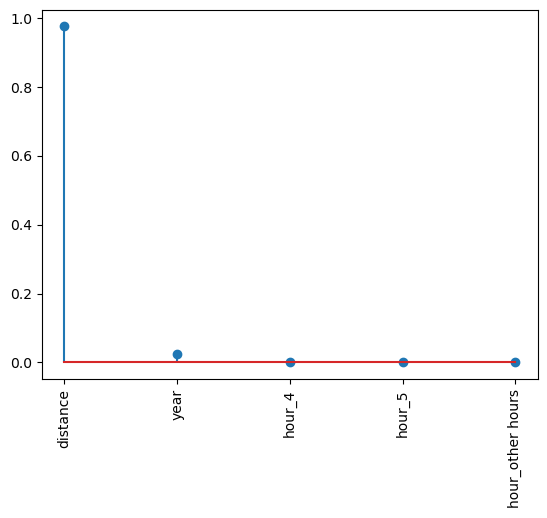

In [80]:
plt.stem(RFR.feature_importances_)
plt.xticks(range(len(x_changed.columns)), x_changed.columns, rotation = 'vertical')
plt.show()

### All Features

In [81]:
x_tr, x_tt, y_tr, y_tt = train_test_split(x, y, test_size = 0.3)

In [82]:
LR.fit(x_tr , y_tr)
LasCV.fit(x_tr , y_tr)
RidCV.fit(x_tr , y_tr)
ElaNetCV.fit(x_tr , y_tr)
KNNCV.fit(x_tr , y_tr)
RFR.fit(x_tr , y_tr)

print(LasCV.best_estimator_)
print(RidCV.best_estimator_)
print(ElaNetCV.best_estimator_)
print(KNNCV.best_estimator_)


Lasso(alpha=0.001)
Ridge(alpha=100)
ElasticNet(alpha=0.001, l1_ratio=0.1)
KNeighborsRegressor(n_neighbors=29)


In [83]:
y_tt_predict_LR = LR.predict(x_tt)
y_tt_predict_Las = LasCV.predict(x_tt)
y_tt_predict_Rid = RidCV.predict(x_tt)
y_tt_predict_ElaNet = ElaNetCV.predict(x_tt)
y_tt_predict_KNN = KNNCV.predict(x_tt)
y_tt_predict_RFR = RFR.predict(x_tt)

In [84]:
# MSE
print("MSE Linear Regression: ", MSE(y_tt_predict_LR, y_tt))
print("MSE Lasso: ", MSE(y_tt_predict_Las, y_tt))
print("MSE Ridge: ", MSE(y_tt_predict_Rid, y_tt))
print("MSE Elastic Net: ", MSE(y_tt_predict_ElaNet, y_tt))
print("MSE KNN: ", MSE(y_tt_predict_KNN, y_tt))
print("MSE Random Forest: ", MSE(y_tt_predict_RFR, y_tt), "\n")

# MAE
print("MAE Linear Regression: ", MAE(y_tt_predict_LR, y_tt))
print("MAE Lasso: ", MAE(y_tt_predict_Las, y_tt))
print("MAE Ridge: ", MAE(y_tt_predict_Rid, y_tt))
print("MAE Elastic Net: ", MAE(y_tt_predict_ElaNet, y_tt))
print("MAE KNN: ", MAE(y_tt_predict_KNN, y_tt))
print("MAE Random Forest: ", MAE(y_tt_predict_RFR, y_tt), "\n")

#R²
print("R² Linear Regression: ", r2(y_tt_predict_LR, y_tt))
print("R² Lasso: ", r2(y_tt_predict_Las, y_tt))
print("R² Ridge: ", r2(y_tt_predict_Rid, y_tt))
print("R² Elastic Net: ", r2(y_tt_predict_ElaNet, y_tt))
print("R² KNN: ", r2(y_tt_predict_KNN, y_tt))
print("R² Random Forest: ", r2(y_tt_predict_RFR, y_tt), "\n")

MSE Linear Regression:  15.938341484325392
MSE Lasso:  15.93767800846773
MSE Ridge:  15.937653699678485
MSE Elastic Net:  15.937644321655839
MSE KNN:  14.616404365048702
MSE Random Forest:  15.397411467490228 

MAE Linear Regression:  2.149738352939564
MAE Lasso:  2.149222757829054
MAE Ridge:  2.1495626028118195
MAE Elastic Net:  2.1494717351716344
MAE KNN:  2.035024915495767
MAE Random Forest:  2.09243965656202 

R² Linear Regression:  0.7849967455343112
R² Lasso:  0.7849627371693619
R² Ridge:  0.7849739126007464
R² Elastic Net:  0.7849624939549666
R² KNN:  0.8022901962735494
R² Random Forest:  0.7757503950009029 



In [93]:
lasso_coef = pd.DataFrame({'Feature': x.columns, 'Lasso Coefficient': LasCV.best_estimator_.coef_})
lasso_coef

,Feature,Lasso Coefficient
0,distance,2.369142e+00
1,year,5.171727e-01
2,passenger_count,5.713598e-02
3,day_Friday,1.994805e-01
4,day_Monday,-1.857204e-01
5,day_Saturday,-2.352866e-01
6,day_Sunday,-3.561368e-01
7,day_Thursday,1.799640e-01
8,day_Tuesday,0.000000e+00
9,day_Wednesday,1.624439e-01


#### Lasso regression revealed that the coefficients of the attributes 'day_Tuesday' and 'period_morning' were zeroed, indicating these attributes do not significantly contribute to the predictive model, potentially being less relevant or redundant.

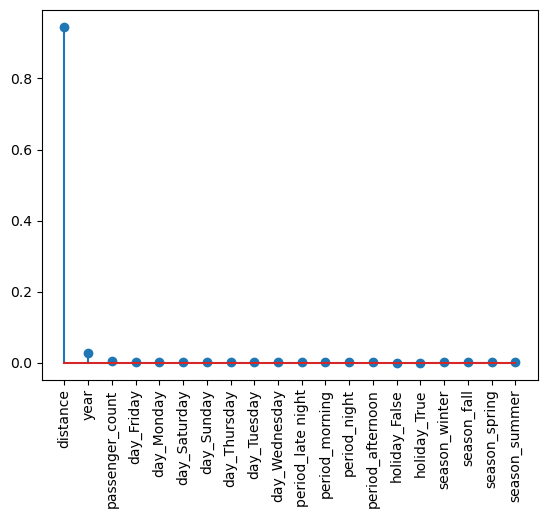

In [87]:
plt.stem(RFR.feature_importances_)
plt.xticks(range(len(x.columns)), x.columns, rotation = 'vertical')
plt.show()

####

#### Following the exploratory data analysis, modeling commenced based on the most promising features for explaining the fare value.
#### The initial model exclusively factored in distance, given its notable prominence both visually and numerically.
#### Subsequently, considerations expanded to encompass not only distance but also time and year. Within the time variable, a distinction was made for the hours 4 and 5, recognized as particularly influential in this category.
#### Eventually, all remaining features were included for consideration, as none exhibited significant prominence. This approach was chosen for comparative purposes.
#### Despite distance initially appearing as the sole highly influential variable, upon comparing the $R^2$, MSE, and MAE of the three models, the one incorporating all features emerged as the best performer.
#### Following a comprehensive analysis, the conclusion drawn is that the Lasso regression model, encompassing all features, distinguishes itself as a superior model due to its good interpretability and inherent feature selection capability. Despite these strengths, it also yielded similar performance metrics (MSE, MAE, and $R^2$) when compared to the other models.